In [11]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
import string

# Part 1: Data Engineering

In [2]:
## https://www.kaggle.com/crowdflower/twitter-airline-sentiment/kernels
df = pd.read_csv('data/twitter-airline-sentiment/tweets.csv',usecols=['text', 'airline_sentiment'])

In [3]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [4]:
from lib.utility import ProcessPipeline

In [5]:
myPipeline = ProcessPipeline()

In [6]:
df.text[1]

"@VirginAmerica plus you've added commercials to the experience... tacky."

In [7]:
df.text = list(map(lambda x:myPipeline.pre_process(x,return_str=True,steps=['remove_digits','remove_stopwords','remove_punctuation']),df.text))

In [8]:
df.text[1]

'VirginAmerica plus youve added commercials experience tacky'

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

In [26]:
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])

# Train data samples: 13176
# Test data samples: 1464


In [27]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    13176.000000
mean        10.239071
std          4.001735
min          1.000000
25%          7.000000
50%         11.000000
75%         13.000000
max         22.000000
Name: text, dtype: float64

# Part 2: Feature Engineering

### Texts to sequences: <br>

#### I utilized keras API, parameter interpotation <br>
- num_words: the maximum number of words to keep, based on word frequency. Only the most common num_words words will be kept.
- filters: a string where each element is a character that will be filtered from the texts. The default is all punctuation, plus tabs and line breaks, minus the ' character.
- lower: boolean. Whether to convert the texts to lowercase.
- split: str. Separator for word splitting.
- char_level: if True, every character will be treated as a token.
- oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls

In [28]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Sizes of the batches used in the mini-batch gradient descent
MAX_LEN = 24  # Maximum number of words in a sequence
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings


In [29]:
### keras text to sequence: https://keras.io/preprocessing/text/
tk = Tokenizer(num_words=NB_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [30]:
X_train.values[0]

'USAirways kind screwed day least outbound save stranding RenHotels MarriottRewards'

In [31]:
X_train_seq[0]

[3, 628, 919, 53, 281, 1760, 1080, 2665, 5554, 5555]

In [32]:
X_train[1]

'VirginAmerica plus youve added commercials experience tacky'

In [33]:
X_train_seq[1]

[4, 56, 1628, 1135, 93, 3179, 2666, 1258, 650, 3924, 460, 920]

In [34]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [35]:
X_test_seq_trunc[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    4,   74,  493, 1349,  669,   28,  401, 1820,
         50,  835], dtype=int32)

### Converting the target classes to numbers¶


In [36]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [37]:
y_test_le

array([0, 0, 0, ..., 0, 0, 1])

In [38]:
y_test_oh

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

### Splitting off validation data¶


In [39]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (1318, 24)


# Part 3 Embedding

In [40]:
X_train_emb[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   3,  32, 165, 217, 324, 952, 301,   2, 205, 920], dtype=int32)

## Part 3.1 Training word embedding

In [80]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 50, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(3, activation='softmax'))
emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 50)            500000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3603      
Total params: 503,603
Trainable params: 503,603
Non-trainable params: 0
_________________________________________________________________


In [81]:
emb_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = emb_model.fit(X_train_emb, y_train_emb, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_valid_emb, y_valid_emb), verbose=1)

Train on 11858 samples, validate on 1318 samples
Epoch 1/10
11858/11858 [==============================] - 1s 104us/step - loss: 0.9920 - acc: 0.5970 - val_loss: 0.9095 - val_acc: 0.6214
Epoch 2/10
11858/11858 [==============================] - 0s 25us/step - loss: 0.8519 - acc: 0.6300 - val_loss: 0.8142 - val_acc: 0.6548
Epoch 3/10
11858/11858 [==============================] - 0s 35us/step - loss: 0.7495 - acc: 0.6677 - val_loss: 0.7370 - val_acc: 0.6639
Epoch 4/10
11858/11858 [==============================] - 0s 38us/step - loss: 0.6559 - acc: 0.7103 - val_loss: 0.6701 - val_acc: 0.7018
Epoch 5/10
11858/11858 [==============================] - 0s 36us/step - loss: 0.5637 - acc: 0.7853 - val_loss: 0.6167 - val_acc: 0.7458
Epoch 6/10
11858/11858 [==============================] - 0s 36us/step - loss: 0.4818 - acc: 0.8410 - val_loss: 0.5788 - val_acc: 0.7640
Epoch 7/10
11858/11858 [==============================] - 0s 37us/step - loss: 0.4141 - acc: 0.8741 - val_loss: 0.5536 - val_acc

#### Plot accuracy

In [82]:
history.history

{'val_loss': [0.9094500373455389,
  0.8142009768211064,
  0.7370490401033567,
  0.6700739018472084,
  0.6167422453441822,
  0.5787621633416785,
  0.5535592438599408,
  0.5384679414976349,
  0.526974832704107,
  0.5264616638467235],
 'val_acc': [0.6213960511912344,
  0.6547799714599285,
  0.6638846781800115,
  0.7018209393722696,
  0.7458270107126019,
  0.7640364156507397,
  0.7708649463465435,
  0.7807283784080529,
  0.7936267007102735,
  0.7921092548211175],
 'loss': [0.991989968397662,
  0.8518764811837667,
  0.7494877327712959,
  0.6558780843581452,
  0.5637437854735641,
  0.48176516546007153,
  0.414083585939795,
  0.3570329244079709,
  0.31063306395471507,
  0.27271524386354473],
 'acc': [0.5969809410060954,
  0.6299544611433985,
  0.667650531307001,
  0.7103221452563906,
  0.7852926294082613,
  0.8409512566764151,
  0.8740934388374957,
  0.895935233406563,
  0.9117895093429026,
  0.9239332095570177]}

In [83]:
metric_name = "acc"

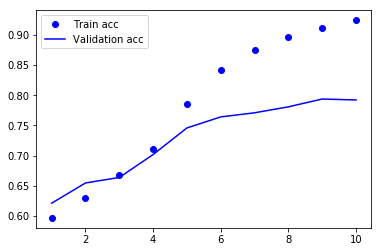

In [84]:
metric = history.history[metric_name]
val_metric = history.history['val_' + metric_name]

e = range(1, EPOCHS + 1)

plt.plot(e, metric, 'bo', label='Train ' + metric_name)
plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
plt.legend()
plt.show()

In [27]:
metric_name = "loss"

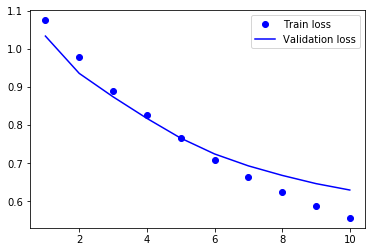

In [28]:
metric = history.history[metric_name]
val_metric = history.history['val_' + metric_name]

e = range(1, EPOCHS + 1)

plt.plot(e, metric, 'bo', label='Train ' + metric_name)
plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
plt.legend()
plt.show()

## Part 3.2 Modeling based on pre-trained word embedding

#### Intro to glove embedding: https://nlp.stanford.edu/projects/glove/

import urllib.request
urllib.request.urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", "lib/gloveEmb.zip")

import zipfile
zip_ref = zipfile.ZipFile("lib/gloveEmb.zip", 'r')
zip_ref.extractall("lib")
zip_ref.close()

In [85]:
!ls lib


__init__.py       glove.6B.200d.txt gloveEmb.zip
__pycache__       glove.6B.300d.txt nlp.py
glove.6B.100d.txt glove.6B.50d.txt  utility.py


In [86]:
glove_file = 'glove.6B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open("lib/" + glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [87]:
len(emb_dict)

400000

In [92]:
X_train[1]

'VirginAmerica plus youve added commercials experience tacky'

In [93]:
airline_words = X_train[1].split(" ")
for w in airline_words:
    if w in emb_dict.keys():
        print('Found the word {} in the dictionary'.format(w))

Found the word plus in the dictionary
Found the word added in the dictionary
Found the word commercials in the dictionary
Found the word experience in the dictionary
Found the word tacky in the dictionary


In [ ]:
TAump

In [96]:
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [97]:
emb_matrix.shape

(10000, 100)

In [98]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(3, activation='softmax'))
glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 24, 100)           1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 7203      
Total params: 1,007,203
Trainable params: 1,007,203
Non-trainable params: 0
_________________________________________________________________


In [101]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = True

In [102]:
glove_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = glove_model.fit(X_train_emb, y_train_emb, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_valid_emb, y_valid_emb), verbose=1)

Train on 11858 samples, validate on 1318 samples
Epoch 1/10
11858/11858 [==============================] - 2s 144us/step - loss: 0.5485 - acc: 0.7832 - val_loss: 0.6177 - val_acc: 0.7451
Epoch 2/10
11858/11858 [==============================] - 1s 68us/step - loss: 0.4973 - acc: 0.8107 - val_loss: 0.5977 - val_acc: 0.7527
Epoch 3/10
11858/11858 [==============================] - 1s 71us/step - loss: 0.4574 - acc: 0.8258 - val_loss: 0.5897 - val_acc: 0.7587
Epoch 4/10
11858/11858 [==============================] - 1s 72us/step - loss: 0.4211 - acc: 0.8403 - val_loss: 0.5775 - val_acc: 0.7602
Epoch 5/10
11858/11858 [==============================] - 1s 73us/step - loss: 0.3883 - acc: 0.8549 - val_loss: 0.5710 - val_acc: 0.7648
Epoch 6/10
11858/11858 [==============================] - 1s 79us/step - loss: 0.3593 - acc: 0.8702 - val_loss: 0.5651 - val_acc: 0.7709
Epoch 7/10
11858/11858 [==============================] - 1s 75us/step - loss: 0.3308 - acc: 0.8853 - val_loss: 0.5628 - val_acc

In [103]:
metric_name = 'acc'

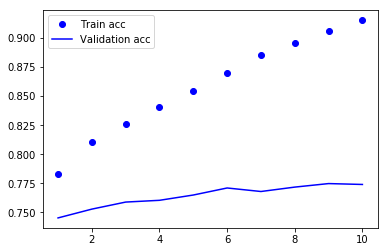

In [104]:
metric = history.history[metric_name]
val_metric = history.history['val_' + metric_name]

e = range(1, EPOCHS + 1)

plt.plot(e, metric, 'bo', label='Train ' + metric_name)
plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
plt.legend()
plt.show()